# Simulation of Spread Trading
### Jinyuan Tian

### 1. Initialization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import functools
import seaborn as sns
import sys
import statsmodels.formula.api as smf
#from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats.stats import pearsonr
from datetime import datetime
import pandas_datareader.data as web

stocks=['RING', "GDX"]
strCloseX="RING:Adj_Close"
strRtnX="RING:Percent"
strCloseY="GDX:Adj_Close"
strRtnY="GDX:Percent"
strDolVolX="RING:Dollar_Volume"
strRollVolX="RING:Rolling_Volume"
strMTM='MTM'
strPNL='PNL'

col_lst = [strCloseX, strCloseY, "RING:Volume"]
d_bgn=datetime(2013,12,31)
d_end=datetime(2015,12,31)

### 2. Load Data

In [2]:
raw_data1=web.DataReader(stocks[0], 'yahoo', d_bgn, d_end)
raw_data2=web.DataReader(stocks[1], 'yahoo', d_bgn, d_end)

renamed_data = pd.DataFrame({'RING:Adj_Close':raw_data1['Adj Close'],'GDX:Adj_Close': raw_data2['Adj Close'],
                     'RING:Volume':raw_data1['Volume']})
renamed_data.head(3)


,GDX:Adj_Close,RING:Adj_Close,RING:Volume
Date,,,
2013-12-31,20.753500,17.666191,78500
2014-01-02,21.637465,18.286739,54400
2014-01-03,21.441028,18.228561,48500


### 3. Adding Dollar Volume, Rolling Volume and End-of-Trading-Month Flag

In [3]:
renamed_data[strDolVolX] = pd.Series(renamed_data[strCloseX]*renamed_data['RING:Volume'], 
                                              index=renamed_data.index)
renamed_data[strRollVolX] = renamed_data[strDolVolX].rolling(window=15).median()

renamed_data['nextday'] = renamed_data.index
renamed_data['nextday'] = renamed_data['nextday'].shift(-1)
renamed_data['EOM'] = renamed_data['nextday'].dt.month != renamed_data.index.month 
renamed_data.dropna(inplace=True)
# the maximum capital 
parK=np.max(renamed_data[strRollVolX])*2
renamed_data.head(3)
#print(parK)

,GDX:Adj_Close,RING:Adj_Close,RING:Volume,RING:Dollar_Volume,RING:Rolling_Volume,nextday,EOM
Date,,,,,,,
2014-01-22,22.678578,19.101207,31300,5.978678e+05,791988.3972,2014-01-23,False
2014-01-23,23.297351,19.702361,97300,1.917040e+06,791988.3972,2014-01-24,False
2014-01-24,23.248243,19.624792,89100,1.748569e+06,791988.3972,2014-01-27,False


### Supporting Functions
#### Parameters:
#### M: use M days return to construct spread
#### G: parameters for entering positions
#### J: parameters for exiting positions
#### S: parameters for stop loss

In [4]:
def trade_run(M, G, J, S):
    # implement spread trading
    res_data = renamed_data.copy()
    res_data[strRtnX] = res_data[strCloseX].pct_change(M)
    res_data[strRtnY] = res_data[strCloseY].pct_change(M)
    res_data['nSpread'] = res_data[strRtnX]-res_data[strRtnY]

    res_data = res_data[[strCloseX, strCloseY, strRollVolX, 'EOM','nSpread']].dropna()
    res_data['fEnter'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)
    res_data['fExit'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)
    res_data['fStopLoss'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)
    res_data['posX'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)
    res_data['posY'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)
    res_data['MTM'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)
    res_data['PNL'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)
    res_data['CumPNL'] = pd.Series(np.zeros(len(res_data.index)), index=res_data.index)

    tmpFIn=False # in position
    tmpPosX=0
    tmpPosY=0
    tmpCloseX=0
    tmpCloseY=0
    tmpFLong=0
    tmpCumPNL=0
    trade_data = list()


    for idx,row in res_data.iterrows():

        if tmpFIn:
            row['posX'] = tmpPosX
            row['posY'] = tmpPosY
            row['MTM'] = (tmpPosX * (row[strCloseX] - tmpCloseX) + tmpPosY * (row[strCloseY] - tmpCloseY))

            # Exit if position loss exceeds threshold or spread reverts
            if row['MTM'] < - S * (abs(tmpPosX) * tmpCloseX + abs(tmpPosY) * tmpCloseY): 
                row['fStopLoss'] = True
            elif (- tmpFLong * row['nSpread']) < J : # maintain position
                row['fExit'] = True

            # Exit on last trading day of the month
            if row['fStopLoss'] or row['fExit'] or row['EOM']: 
                row['PNL'] = (tmpPosX * (row[strCloseX] - tmpCloseX) + tmpPosY * (row[strCloseY] - tmpCloseY))
                row['MTM'] = 0
                tmpCloseX = 0
                tmpCloseY = 0
                tmpPosX = 0
                tmpPosY = 0
                tmpFIn = False

        if  not(tmpFIn) and not(row['EOM']) and (abs(row['nSpread']) >= G) and idx.day < 25: # enter position
                # Do not enter position on EOM 
                # or (optionally) towards the month end: this might help to avoid the time period too short to 
                # revert the spread
            tmpFLong = 1 
            if row['nSpread'] > 0: tmpFLong = -1

            tmpCloseX = row[strCloseX]
            tmpCloseY = row[strCloseY]
            tmpPosX = tmpFLong * int(row[strRollVolX]/100/tmpCloseX) 
            tmpPosY = -tmpFLong * int(row[strRollVolX]/100/tmpCloseY)
            tmpFIn = True
            row['fEnter'] = True
            row['posX'] = tmpPosX
            row['posY'] = tmpPosY
            row['MTM'] = (tmpPosX * (row[strCloseX] - tmpCloseX) + tmpPosY * (row[strCloseY] - tmpCloseY))

        row['CumPNL'] = row['PNL'] + tmpCumPNL
        tmpCumPNL = row['CumPNL'] 
        row['%CapChg'] = tmpCumPNL / parK 

        if row['fEnter'] or row['fStopLoss'] or row['fExit'] or row['EOM']: 
            trade_data.append(row)

        # if capital used up, stop trading
        if (tmpCumPNL + parK) < 0: break # bankrupt    

    trade_df = pd.DataFrame(trade_data)
    return trade_df

In [5]:
# keep tracking of the maximum total P&L
def mark_max(df_trade_run, params):
    global maxPar 
    global maxPNL 
    global maxDF
    if df_trade_run['CumPNL'][-1] > maxPNL:
        maxPNL = df_trade_run['CumPNL'][-1]
        maxPar = params
        maxDF = df_trade_run

In [6]:
# summary of trade execution for each combination of parameters
def update_summary(df_trade_run, parRun):
    global res_summary
    pnl=df_trade_run['PNL'][df_trade_run['PNL']!= 0]
    parRun.append(np.sum(pnl))
    parRun.append(np.mean(pnl))
    parRun.append(np.std(pnl))
    parRun.append(np.max(pnl))
    parRun.append(np.min(pnl))
    parRun.append(np.mean(pnl) / np.std(pnl))
    parRun.append(len(pnl))
    parRun.append(df_trade_run['%CapChg'][-1])
    res_summary.append(parRun)

In [7]:
res_summary = list()
maxPar = list()
maxDF = None
maxPNL = 0

for M in np.arange(1, 21, 1): # set levels of M 1-20
    sys.stdout.write("%5d\n"%M)
    pct_data = renamed_data[col_lst[0:2]].pct_change(M)
    pct_data.rename(columns={strCloseX:strRtnX, strCloseY:strRtnY}, inplace=True)
    pct_data['nSpread'] = pct_data[strRtnX] - pct_data[strRtnY]
    pct_data.dropna(inplace=True)
    
    spdMax = max(abs(pct_data['nSpread']))
    spdMin = min(abs(pct_data['nSpread']))
    spdAvg = abs(np.mean(pct_data['nSpread']))
    
    # for each M-day return, the threshold G and J and determined dynamically 
    # as longer return tends to have bigger spread
    for lvlJ in np.arange(-1, 4, 1):  # Test J
        J = (1+0.5*lvlJ)*spdAvg # 0.5*spdAvg ~ 3*spdAvg
        # statically 5 levels of S, little impact on results
        for S in np.arange(0.02, 0.11, 0.02): # Test S
            stepsize = max(0.001, (spdMax*0.5 - J) / 10 ) 
            # G ranges from J to half of max spread
            # 10 levels 
            for G in np.arange(J+stepsize, spdMax*0.5+0.001, stepsize): # Test G
                trade_df = trade_run(M, G, J, S)
                update_summary(trade_df, [M, G, J, S])
                mark_max(trade_df, [M, G, J, S])
                sys.stdout.write('.')           
    print("")

df_res_summary = pd.DataFrame(res_summary, columns=['M', 'G', 'J', 'S', 'Total', 'Mean', 'Std', 'Max',
                                                    'Min', 'Mean/Std', '#Trades', '% Cap Change'])

df_res_summary.to_csv('Test_Summary.csv')
max(df_res_summary['Total'])

    1
..........................................................................................................................................................................................................................................................
    2
..........................................................................................................................................................................................................................................................
    3
..........................................................................................................................................................................................................................................................
    4
...............................................................................................................................................................................................................................

4964.7292150000012

### 4. Draw some plots for parameter analysis

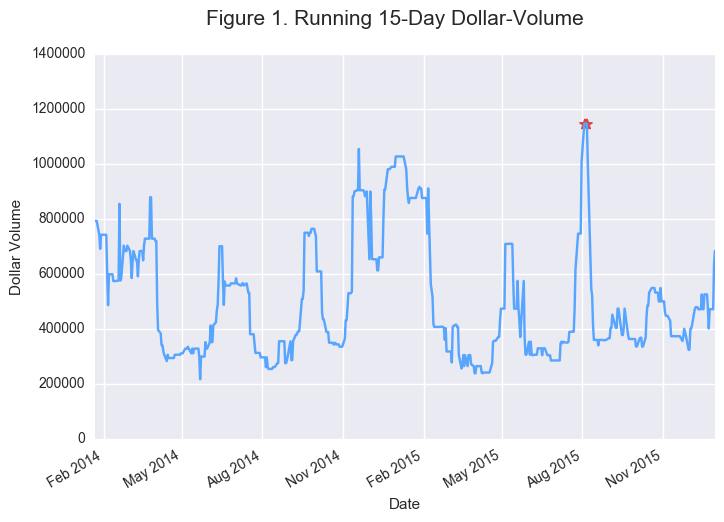

In [8]:
fig,ax =plt.subplots()

plt.style.use('ggplot')
plt.suptitle('Figure 1. Running 15-Day Dollar-Volume', fontsize=15)

# Plot 1
#g_sct = []
renamed_data[strRollVolX].plot(ax=ax, color='#58A5FF')
#line1, =ax.plot(renamed_data[strRollVolX].index, renamed_data[strRollVolX], color='#58A5FF')
#g_sct.append(line1)
tmpMaxDF=renamed_data[strRollVolX][renamed_data[strRollVolX]==np.max(renamed_data[strRollVolX])]
ax.scatter(tmpMaxDF.index, tmpMaxDF, color='#DA4541', s=64, marker="*")
ax.set_ylabel('Dollar Volume')


plt.savefig('RollVol.jpg')

In [9]:
df_res_summary.head(3)

,M,G,J,S,Total,Mean,Std,Max,Min,Mean/Std,#Trades,% Cap Change
0,1,0.001354,0.000085,0.02,4277.883701,18.126626,25.941444,160.943229,-88.970208,0.698752,236,0.001867
1,1,0.002624,0.000085,0.02,4285.180679,21.533571,27.502766,160.943229,-88.970208,0.782960,199,0.001870
2,1,0.003893,0.000085,0.02,4218.145010,24.382341,27.586671,160.943229,-88.970208,0.883845,173,0.001841


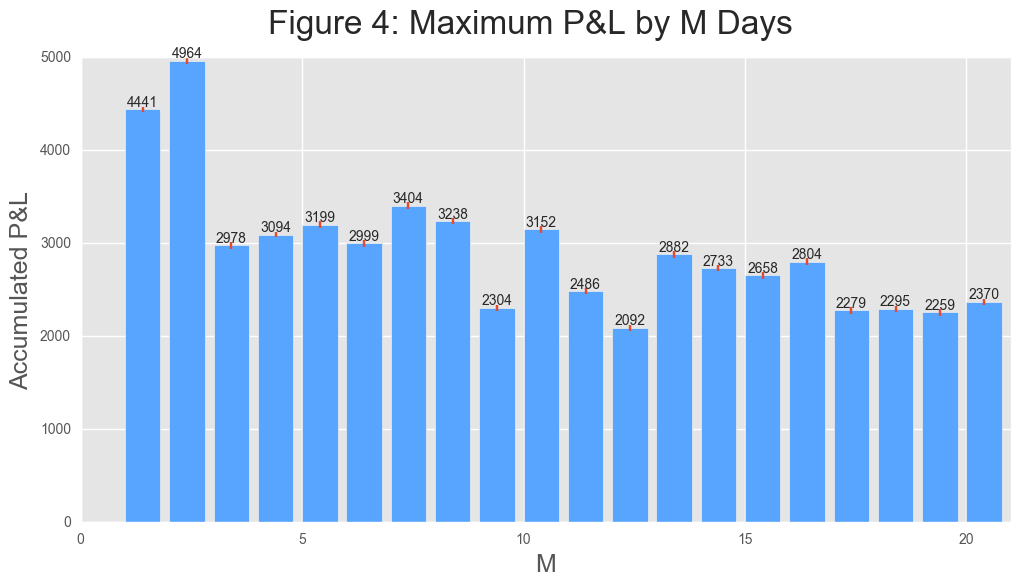

In [10]:
idx = df_res_summary.groupby(['M'])['Total'].transform(max) == df_res_summary['Total']
tmp_df = df_res_summary[idx]
idx = tmp_df.groupby(['M'])['S'].transform(min) == tmp_df['S']
df_maxPNL_by_M = tmp_df[idx]

## Plot Max PNL by M 
fig, ax =plt.subplots(1, figsize=(12, 6))
plt.style.use('ggplot')
plt.suptitle('Figure 4: Maximum P&L by M Days', fontsize=24)

#ax.hold(True)
bar1 = ax.bar(df_maxPNL_by_M['M'], df_maxPNL_by_M['Total'], color='#58A5FF', yerr=df_maxPNL_by_M['Std'].values)
ax.set_ylabel('Accumulated P&L', fontsize=18)
ax.set_xlabel('M', fontsize=18)
ax.set_xlim([0, 21])

rects = ax.patches
# Now make some text
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, '%d' %height, ha='center', va='bottom')

In [11]:
maxDF.head(3)

,RING:Adj_Close,GDX:Adj_Close,RING:Rolling_Volume,EOM,nSpread,fEnter,fExit,fStopLoss,posX,posY,MTM,PNL,CumPNL,%CapChg
2014-01-24,19.624792,23.248243,791988.3972,False,0.002292,True,0,0.0,-403.0,340.0,0.0,0.000000,0.000000,0.000000
2014-01-27,19.004246,22.482141,741363.4152,False,-0.000442,0,True,0.0,-403.0,340.0,0.0,-10.394642,-10.394642,-0.000005
2014-01-31,19.333912,23.061628,741363.4152,True,-0.004293,0,0,0.0,0.0,0.0,0.0,0.000000,-10.394642,-0.000005


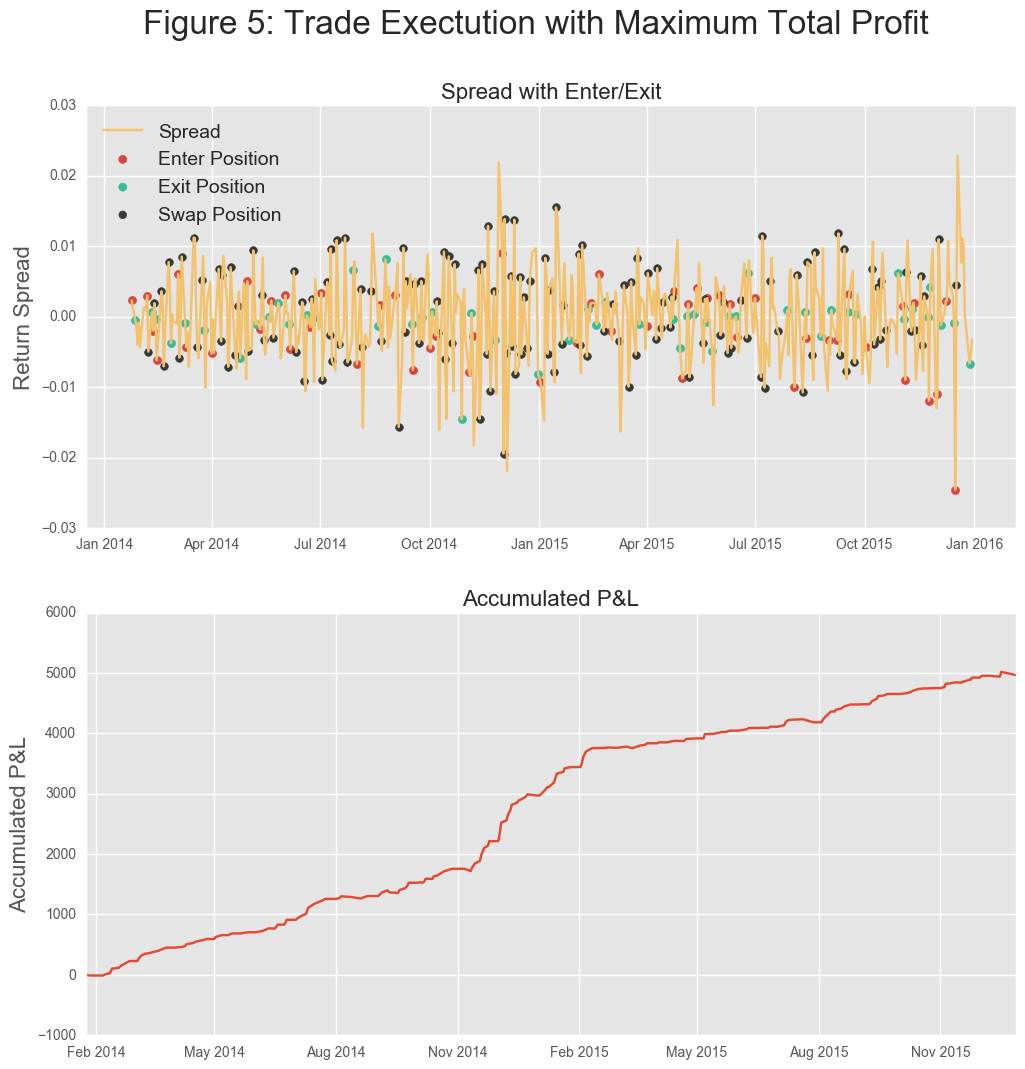

In [12]:
fig, (ax, ax2) =plt.subplots(2, figsize=(12, 12))

M=maxPar[0]
pct_data = renamed_data[col_lst[0:2]][M:]  / renamed_data[col_lst[0:2]][:-M] .values -1
pct_data.rename(columns={strCloseX:strRtnX, strCloseY:strRtnY}, inplace=True)
pct_data['nSpread'] = pct_data[strRtnX] - pct_data[strRtnY]

makersize=36
plt.style.use('ggplot')
plt.suptitle('Figure 5: Trade Exectution with Maximum Total Profit', fontsize=24)

# Plot 1
ax.hold(True)
g_sct = []
line1, =ax.plot(pct_data['nSpread'], color='#F4C26C')
g_sct.append(line1)
g_sct.append(ax.scatter(maxDF[(maxDF['fEnter']==True)  & (maxDF['fExit']==False)].index, 
                        maxDF[(maxDF['fEnter']==True)  & (maxDF['fExit']==False)]['nSpread'], color='#DA4541', s=33))
g_sct.append(ax.scatter(maxDF[(maxDF['fEnter']==False) & (maxDF['fExit']==True )].index, 
                        maxDF[(maxDF['fEnter']==False) & (maxDF['fExit']==True )]['nSpread'], color='#34BD9A', s=33))
g_sct.append(ax.scatter(maxDF[(maxDF['fEnter']==True)  & (maxDF['fExit']==True )].index, 
                        maxDF[(maxDF['fEnter']==True)  & (maxDF['fExit']==True )]['nSpread'], color='#363737', s=30))

ax.set_ylabel('Return Spread', fontsize=16)
ax.legend(g_sct, ['Spread', 'Enter Position', 'Exit Position', 'Swap Position'], loc='best', fontsize=14)
ax.set_title('Spread with Enter/Exit', fontsize=16)

# Plot 2
ax2.plot(maxDF['CumPNL'])
ax2.set_ylabel('Accumulated P&L', fontsize=16)
ax2.set_title('Accumulated P&L', fontsize=16)



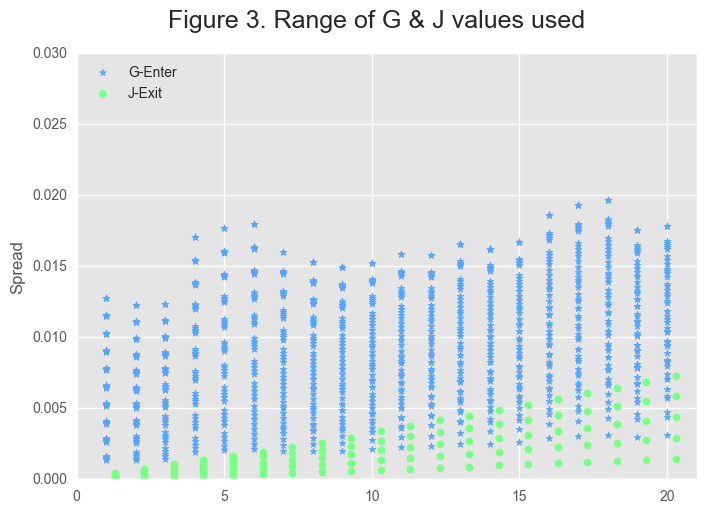

In [13]:
fig, ax =plt.subplots()

plt.style.use('ggplot')
plt.suptitle('Figure 3. Range of G & J values used', fontsize=18)

# Plot 1
g_sct = []
ax.hold(True)
tmpDF = df_res_summary[['M', 'G']].drop_duplicates()
g_sct.append(ax.scatter(tmpDF['M'], tmpDF['G'], color='#58A5FF', s=26, marker="*"))

tmpDF = df_res_summary[['M', 'J']].drop_duplicates()
g_sct.append(ax.scatter(tmpDF['M']+0.3, tmpDF['J'], color='#78FF86', s=26, marker="o"))
ax.set_ylabel('Spread')
ax.set_xlim([0, 21])
ax.set_ylim([0,0.03])
ax.legend(g_sct, ('G-Enter', 'J-Exit'), loc='upper left')


In [14]:
# Test Regression of Return on Parameters
results = smf.ols('Total ~ M + G + J + S', data=df_res_summary).fit()
print(results.summary())
#df_res_summary.to_csv("result_summary.csv")

print(pearsonr(df_res_summary['Total'], df_res_summary['M']))
print(pearsonr(df_res_summary['Total'], df_res_summary['G']))
print(pearsonr(df_res_summary['Total'], df_res_summary['J']))
print(pearsonr(df_res_summary['Total'], df_res_summary['S']))

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     4775.
Date:                Thu, 04 May 2017   Prob (F-statistic):               0.00
Time:                        16:19:50   Log-Likelihood:                -37235.
No. Observations:                5000   AIC:                         7.448e+04
Df Residuals:                    4995   BIC:                         7.451e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3489.5938     20.404    171.029      0.0

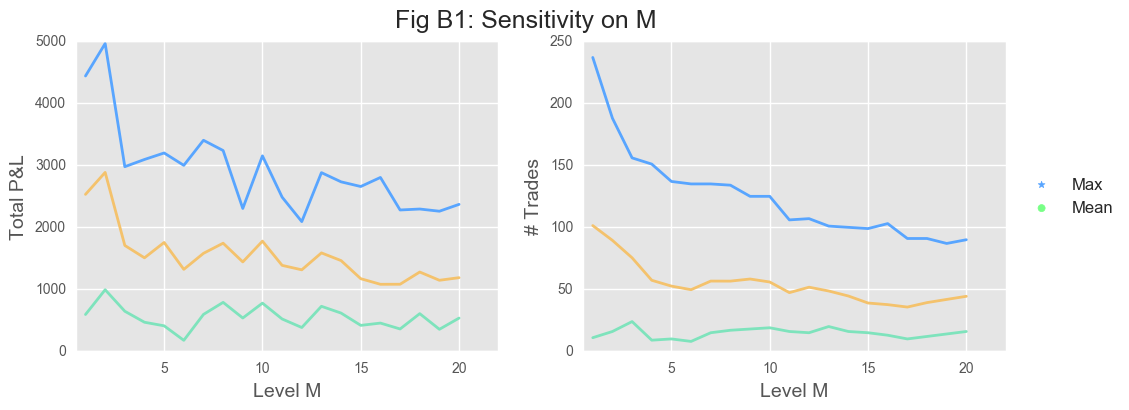

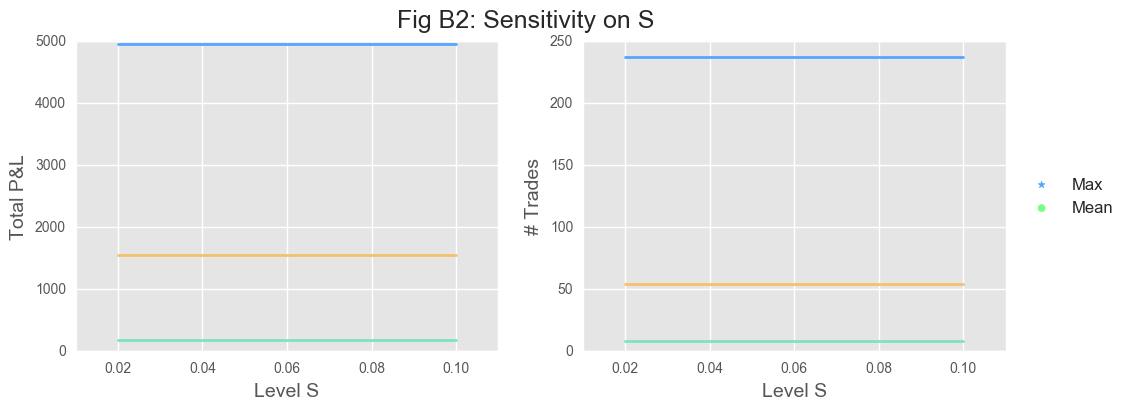

In [15]:
tmpDF = df_res_summary.sort_values(by='G')
g = tmpDF.groupby(['M', 'J', 'S'])
tmpDF['idxG'] = g.cumcount() + 1

tmpDF = tmpDF.sort_values(by='J')
g = tmpDF.groupby(['M', 'G', 'S'])
tmpDF['idxJ'] = g.cumcount() + 1

tmpDF = tmpDF.sort_values(by='S')
g = tmpDF.groupby(['M', 'G', 'J'])
tmpDF['idxS'] = g.cumcount() + 1

def plt_sen_sub(valX, ax, strX, strY, strTitle, strXLabel, strYLabel):
    spdMax = []
    spdMin = []
    spdAvg = []
    
    spdMax=df_res_summary.groupby([strX])[strY].max().tolist()
    spdAvg=df_res_summary.groupby([strX])[strY].mean().tolist()
    spdMin=df_res_summary.groupby([strX])[strY].min().tolist()

    ax.hold(True)
    g_sct = []

    line1, =ax.plot(valX, spdMax, color='#58A5FF', lw='2')
    g_sct.append(line1)
    line2, =ax.plot(valX, spdAvg, color='#F4C26C', lw='2')
    g_sct.append(line2)
    line3, =ax.plot(valX, spdMin, color='#7EE3BC', lw='2')
    g_sct.append(line3)
    ax.set_ylabel(strYLabel, fontsize=14)
    ax.set_xlabel(strXLabel, fontsize=14)
    ax.set_xlim([np.min(valX)*0.5, np.max(valX)*1.1])
    return ax

def plt_sen(strX, strXLbl, strTitle, strTotal, strStd, strTrade, strfn):
    valX = sorted(tmpDF[strX].unique())

    fig, (ax1, ax3) =plt.subplots(1, 2, figsize=(12, 4))
    plt.style.use('ggplot')
    plt.suptitle(strTitle, fontsize=18)

    ax1 = plt_sen_sub(valX, ax1, strX, 'Total'  , strTotal, strXLbl, 'Total P&L')
#     ax2 = plt_sen_sub(valX, ax2, strX, 'Std'    , strStd  , strX, 'Std Dev')
    ax3 = plt_sen_sub(valX, ax3, strX, '#Trades', strTrade, strXLbl, '# Trades')
            
    ax3.legend(g_sct, ['Max', 'Mean', 'Min'], loc='center', fontsize=12, bbox_to_anchor=(1.15, .5),
           ncol=1, fancybox=False, shadow=False, frameon=False)
    
    plt.savefig(strfn)
plt_sen('M'   , 'Level M', 'Fig B1: Sensitivity on M', 'Total vs M', 'StdDev vs M', '# Trades vs M', 'Sen_M.jpg')
# plt_sen('idxG', 'Level G', 'Sensitivity on G', 'Total vs G', 'StdDev vs G', '# Trades vs G', 'Sen_G.jpg')
# plt_sen('idxJ', 'Level J', 'Sensitivity on J', 'Total vs J', 'StdDev vs J', '# Trades vs J', 'Sen_J.jpg')
plt_sen('S' , 'Level S', 'Fig B2: Sensitivity on S', 'Total vs S', 'StdDev vs S', '# Trades vs S', 'Sen_S.jpg')


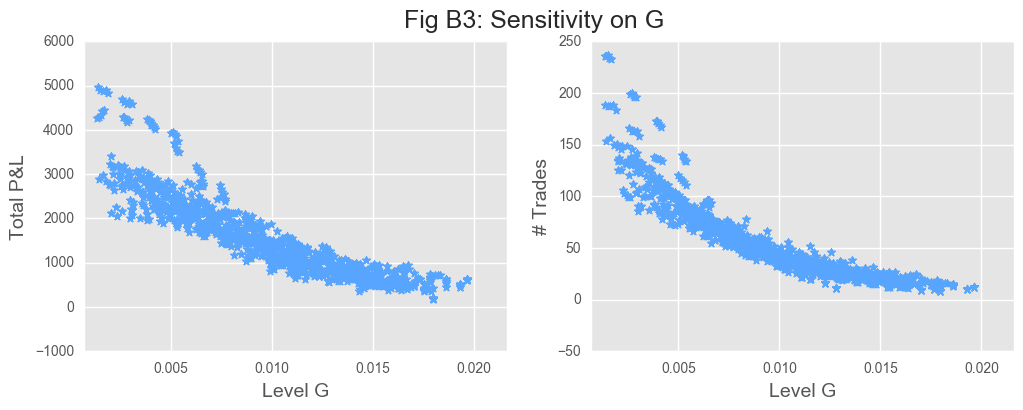

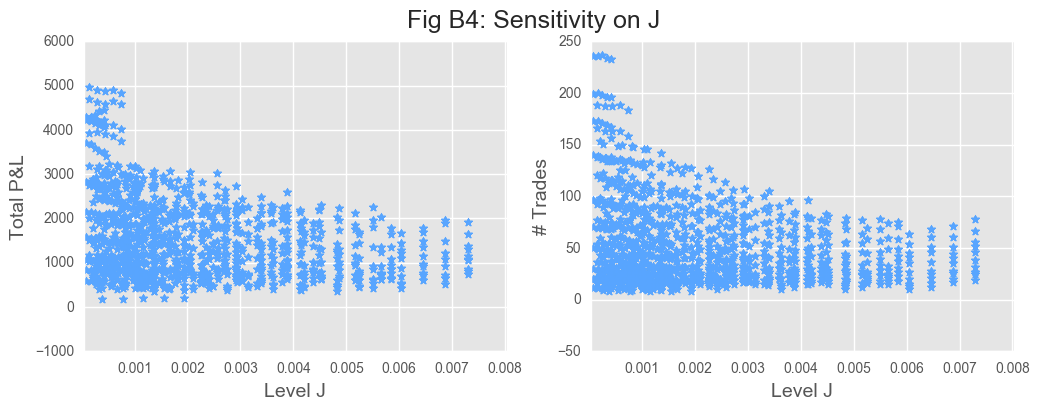

In [16]:
tmpDF = df_res_summary

def plt_sen_sub(strX, ax, strY, strTitle, strXLabel, strYLabel):
    ax.hold(True)
    g_sct = []
    g_sct.append(ax.scatter(tmpDF[strX], tmpDF[strY], color='#58A5FF', s=36, marker="*")) 
    ax.set_ylabel(strYLabel, fontsize=14)
    ax.set_xlabel(strXLabel, fontsize=14)
    ax.set_xlim([np.min(tmpDF[strX])*0.5, np.max(tmpDF[strX])*1.1])
    
    return ax

def plt_sen(strX, strXLbl, strTitle, strTotal, strStd, strTrade, strfn):
    valX = sorted(tmpDF[strX].unique())

    fig, (ax1, ax3) =plt.subplots(1, 2, figsize=(12, 4))
    plt.style.use('ggplot')
    plt.suptitle(strTitle, fontsize=18)

    ax1 = plt_sen_sub(strX, ax1, 'Total'  , strTotal, strXLbl, 'Total P&L')
#     ax2 = plt_sen_sub(valX, ax2, 'Std'    , strStd  , strX, 'Std Dev')
    ax3 = plt_sen_sub(strX, ax3, '#Trades', strTrade, strXLbl, '# Trades')          
#     ax3.legend(g_sct, ['Max', 'Mean', 'Min'], loc='center', fontsize=12, bbox_to_anchor=(1.15, .5),
#            ncol=1, fancybox=False, shadow=False, frameon=False)
    
    plt.savefig(strfn)

# plt_sen('M', 'Level M', 'Sensitivity on M', 'Total vs M', 'StdDev vs M', '# Trades vs M', 'Sen_M.jpg')
plt_sen('G', 'Level G', 'Fig B3: Sensitivity on G', 'Total vs G', 'StdDev vs G', '# Trades vs G', 'Sen_G.jpg')
plt_sen('J', 'Level J', 'Fig B4: Sensitivity on J', 'Total vs J', 'StdDev vs J', '# Trades vs J', 'Sen_J.jpg')
# plt_sen('S', 'Level S', 'Sensitivity on S', 'Total vs S', 'StdDev vs S', '# Trades vs S', 'Sen_S.jpg')